In [504]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.constants import c
import importlib

import tools
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [505]:
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')

In [506]:
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lumapi

In [507]:
icApi = lumapi.INTERCONNECT()

In [508]:
#units
nm = 1e-9
um = 1e-6

In [509]:
#waveguide data
ng = 4.19088 #pdk
neff = 2.44553 #pdk
#bandwidth
wavelength_start = 1530*nm
wavelength_stop = 1565*nm
centralWl = (wavelength_start + wavelength_stop)/2
filenames = ['S_parameters_BB_DC_14um_TE.dat','S_parameters_BB_DC_8um_TE.dat','S_parameters_BB_DC_3um_TE.dat']

In [510]:
importlib.reload(tools)
def calculateDelayLengths(L, FSR1):
    #L = 40*um
    #FSR1 =1.6*nm
    
    deltaLFS = centralWl/neff #eq (3)
    ### DeltaL base ####
    deltaLbase = (centralWl)**2 / (2*FSR1*ng)
    
    deltaLbase2 = deltaLbase/2
    
    deltaLbase3 = deltaLbase/4
    
    ##### SHIFTS #####
    deltaLshifts2st = [0, 0.75*deltaLFS] # A B 
    deltaLshifts1st = [0, 0.25*deltaLFS,0.125*deltaLFS,0.375*deltaLFS] #A B C D
    
    #### delta L por estagio ####
    dl2stA = deltaLbase2 + deltaLshifts2st[0]
    dl2stB = deltaLbase2 + deltaLshifts2st[1]
    dl1stA = deltaLbase3 + deltaLshifts1st[0]
    dl1stB = deltaLbase3 + deltaLshifts1st[1]
    dl1stC = deltaLbase3 + deltaLshifts1st[2]
    dl1stD = deltaLbase3 + deltaLshifts1st[3]
    #### names #####
    names = ['3 st', '2 st A', '2 st B', '1 st A', '1 st B', '1 st C', '1 st D']
    
    
    deltaL = tools.getDeltaL(FSR1, centralWl, ng)
    
    Lpi = tools.getLpi(centralWl, neff)
    #### delay lengths ####
    
    delayLengths = L + np.array([deltaLbase,2*deltaLbase,-2*deltaLbase +Lpi,-2*deltaLbase])
    
    delayLengths2ndA = L + np.array([dl2stA,2*dl2stA,(-2*dl2stA) +Lpi,-2*dl2stA])
    delayLengths2ndB = L + np.array([dl2stB,2*dl2stB,(-2*dl2stB) +Lpi,-2*dl2stB])
    
    delayLengths1stA = L + np.array([dl1stA,2*dl1stA,(-2*dl1stA) +Lpi,-2*dl1stA])
    delayLengths1stB = L + np.array([dl1stB,2*dl1stB,(-2*dl1stB) +Lpi,-2*dl1stB])
    delayLengths1stC = L + np.array([dl1stC,2*dl1stC,(-2*dl1stC) +Lpi,-2*dl1stC])
    delayLengths1stD = L + np.array([dl1stD,2*dl1stD,(-2*dl1stD) +Lpi,-2*dl1stD])
    
    delayLengths_values = [delayLengths,delayLengths2ndA,delayLengths2ndB, delayLengths1stA, delayLengths1stB, delayLengths1stC, delayLengths1stD]
    
    LC = np.array([18.71, 6.3, 6.3, 18.71,11.42])*um #0.5, 0.13, 0.12, 0.5, 0.25
    LC3rd = np.array([17.8, 10, 10, 3.6])*um #0.5 , 0.2, 0.2, 0.04
    LC2nd = np.array([18, 9.75, 6])*um #new = 0.5, 0.25, 0.08; old:0.5 , 0.29, 0.08
    LC1st = np.array([18.89,18.89])*um
    
    return delayLengths_values, names, LC, LC3rd, LC2nd, LC1st


In [511]:
L = 40*um
FSR = 1.6*nm
delayLengths_values, names, LC, LC3rd, LC2nd, LC1st = calculateDelayLengths(L,FSR)
k = [0.5, 0.25,0.08]

## Ideal simulations

In [512]:
importlib.reload(tools)
icApi.switchtolayout()
icApi.deleteall()
tools.placeOna(icApi,'ona1',1000,-200,14,1000,c/wavelength_start, c/wavelength_stop)
for i in range(7):
    tools.MZILatticefilter(icApi,neff,ng,L,delayLengths_values[i],k,LC,filenames, names[i], 3,1)

In [513]:
icApi.refresh()
#positioning compounds
def position():
    icApi.setposition('3 st', 700, 100)
    icApi.setposition('2 st A', 900, -10)
    icApi.setposition('2 st B', 900, 200)
    icApi.setposition('1 st A', 1200, -60)
    icApi.setposition('1 st B', 1200, 40)
    icApi.setposition('1 st C', 1200, 150)
    icApi.setposition('1 st D', 1200, 250)
    return _
position()

np.int64(112)

In [514]:
def connect():    
    icApi.connect('3 st', 'port 2', 'ona1', 'output')
    
    icApi.connect('3 st', 'port 3', '2 st A', 'port 2')
    icApi.connect('3 st', 'port 4', '2 st B', 'port 1')
    
    icApi.connect('2 st A', 'port 3', '1 st A', 'port 2')
    icApi.connect('2 st A', 'port 4', '1 st B', 'port 1')
    
    icApi.connect('2 st B', 'port 3', '1 st C', 'port 2')
    icApi.connect('2 st B', 'port 4', '1 st D', 'port 1')
    
    #outputs to ona
    icApi.connect('1 st A', 'port 3', 'ona1', 'input 1')
    icApi.connect('1 st A', 'port 4', 'ona1', 'input 2')
    icApi.connect('1 st B', 'port 3', 'ona1', 'input 3')
    icApi.connect('1 st B', 'port 4', 'ona1', 'input 4')
    icApi.connect('1 st C', 'port 3', 'ona1', 'input 5')
    icApi.connect('1 st C', 'port 4', 'ona1', 'input 6')
    icApi.connect('1 st D', 'port 3', 'ona1', 'input 7')
    icApi.connect('1 st D', 'port 4', 'ona1', 'input 8')
    return _
connect()

np.int64(112)

In [515]:
## Extra ona connections for each stage
## first stage
icApi.connect('ona1','input 9','3 st', 'port 3')
icApi.connect('ona1','input 10','3 st', 'port 4')
## second stage upper
icApi.connect('ona1','input 11','2 st A', 'port 3')
icApi.connect('ona1','input 12','2 st A', 'port 4')
##seconde stage lower
icApi.connect('ona1','input 13','2 st B', 'port 3')
icApi.connect('ona1','input 14','2 st B', 'port 4')

1.0

In [516]:
icApi.save('MonteCarlo_200GHz_circuit')
icApi.run()

In [517]:
outputsOna = [
    'input 1/mode 1/gain',
    'input 2/mode 1/gain',
    'input 3/mode 1/gain',
    'input 4/mode 1/gain',
    'input 5/mode 1/gain',
    'input 6/mode 1/gain',
    'input 7/mode 1/gain',
    'input 8/mode 1/gain'
]
outputsOna2 = [
    'input 9/mode 1/gain',
    'input 10/mode 1/gain',
    'input 11/mode 1/gain',
    'input 11/mode 1/gain',
    'input 12/mode 1/gain',
    'input 13/mode 1/gain',
    'input 14/mode 1/gain'
    
]


colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
labels = [rf'$\lambda${i+1}' for i in range(8)]

'''
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    ax.plot(data['wavelength']/nm, data["TE gain (dB)"], color=colors[i])

zoom = ax.inset_axes([0.1,0.5,0.3,0.3])
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    zoom.plot(data['wavelength']/nm, data["TE gain (dB)"], color=colors[i])
zoom.grid()
x1, x2, y1, y2 = 1546, 1548, -2, 0.1
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start/nm, wavelength_stop/nm)
plt.ylim(-25, 1)

plt.grid(True)
plt.title('Transmission of a 1:8 demux based on MachZehnder-like lattice filters using ideal devices (200GHz).')
plt.tight_layout()
plt.savefig('TransmissionIdeal200GHz.png', dpi=300)'''

'\nplt.figure(figsize=(10,6))\nax = plt.subplot(111)\nfor i, path in enumerate(outputsOna):\n    data = icApi.getresult(\'ona1\', path)\n    ax.plot(data[\'wavelength\']/nm, data["TE gain (dB)"], color=colors[i])\n\nzoom = ax.inset_axes([0.1,0.5,0.3,0.3])\nfor i, path in enumerate(outputsOna):\n    data = icApi.getresult(\'ona1\', path)\n    zoom.plot(data[\'wavelength\']/nm, data["TE gain (dB)"], color=colors[i])\nzoom.grid()\nx1, x2, y1, y2 = 1546, 1548, -2, 0.1\nzoom.set_xlim(x1, x2)\nzoom.set_ylim(y1, y2)\nax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)\nplt.xlabel(\'Wavelength [nm]\')\nplt.ylabel(\'Transmission [dB]\')\nplt.xlim(wavelength_start/nm, wavelength_stop/nm)\nplt.ylim(-25, 1)\n\nplt.grid(True)\nplt.title(\'Transmission of a 1:8 demux based on MachZehnder-like lattice filters using ideal devices (200GHz).\')\nplt.tight_layout()\nplt.savefig(\'TransmissionIdeal200GHz.png\', dpi=300)'

## Monte Carlo

In [518]:
scriptName = 'Monte Carlo analysis'
icApi.deletesweep(scriptName)
icApi.addsweep(2)

'::Monte Carlo analysis'

In [519]:
trials = 75
scriptName = 'Monte Carlo analysis'
icApi.setsweep('Monte Carlo analysis','name', scriptName)
icApi.setsweep('Monte Carlo analysis', 'name', scriptName)
icApi.setsweep(scriptName, 'number of trials', trials)
icApi.setsweep(scriptName, 'batch size', trials)
icApi.setsweep(scriptName, 'enable seed', 1)
icApi.setsweep(scriptName, 'seed', 1)
icApi.setsweep(scriptName, 'Variation', 'Both')

1.0

## Comprimento do guia de onda Wg3

In [520]:
icApi.switchtolayout()
icApi.refresh()
icApi.groupscope('3 st')
param = icApi.struct()
param['Name'] = f'wg3_length'
param['Parameter'] = f'::Root Element::3 st::wg3::length'
param['Value'] = icApi.getnamed(f'wg3', 'length')
dis = icApi.struct()
dis['type'] = 'gaussian'
dis['variation'] = icApi.getnamed('wg3', 'length')*(1.5/100)
param['Distribution'] = dis
icApi.addsweepparameter(scriptName, param)

'wg3_length'

In [521]:
Tr = icApi.struct()
Tr['Name'] = 'Transmission 3 st A upper port'
Tr['Result'] = f'::Root Element::ona1::input 9/mode 1/gain'
Tr['Estimation'] = False
icApi.addsweepresult(scriptName, Tr)

Tr2 = icApi.struct()
Tr2['Name'] = 'Transmission 3 st A lower port'
Tr2['Result'] = f'::Root Element::ona1::input 10/mode 1/gain'
Tr2['Estimation'] = False
icApi.addsweepresult(scriptName, Tr2)
##

Tr3 = icApi.struct()
Tr3['Name'] = 'Transmission 2 st A upper port'
Tr3['Result'] = f'::Root Element::ona1::input 11/mode 1/gain'
Tr3['Estimation'] = False
icApi.addsweepresult(scriptName, Tr3)

Tr4 = icApi.struct()
Tr4['Name'] = 'Transmission 2 st A lower port'
Tr4['Result'] = f'::Root Element::ona1::input 12/mode 1/gain'
Tr4['Estimation'] = False
icApi.addsweepresult(scriptName, Tr4)

##

Tr5 = icApi.struct()
Tr5['Name'] = 'Transmission 2 st B upper port'
Tr5['Result'] = f'::Root Element::ona1::input 13/mode 1/gain'
Tr5['Estimation'] = False
icApi.addsweepresult(scriptName, Tr5)

Tr6 = icApi.struct()
Tr6['Name'] = 'Transmission 2 st B lower port'
Tr6['Result'] = f'::Root Element::ona1::input 14/mode 1/gain'
Tr6['Estimation'] = False
icApi.addsweepresult(scriptName, Tr6)

##
for i in range(len(outputsOna)):
        Tr = icApi.struct()
        Tr['Name'] = "Transmission"
        Tr['Result'] = f"::Root Element::ona1::input {i + 1}/mode 1/gain"
        Tr['Estimation'] = True
        icApi.addsweepresult(scriptName, Tr)

In [522]:
icApi.save('mc_sweep')
icApi.runsweep(scriptName)

In [523]:
res = icApi.getsweepresult(scriptName, 'Transmission 3 st A upper port')
res2 = icApi.getsweepresult(scriptName, 'Transmission 2 st A upper port')
res3 = icApi.getsweepresult(scriptName, 'Transmission')
wl = res['wavelength'].flatten()

## Saída estagio de entrada

In [524]:
icApi.run()

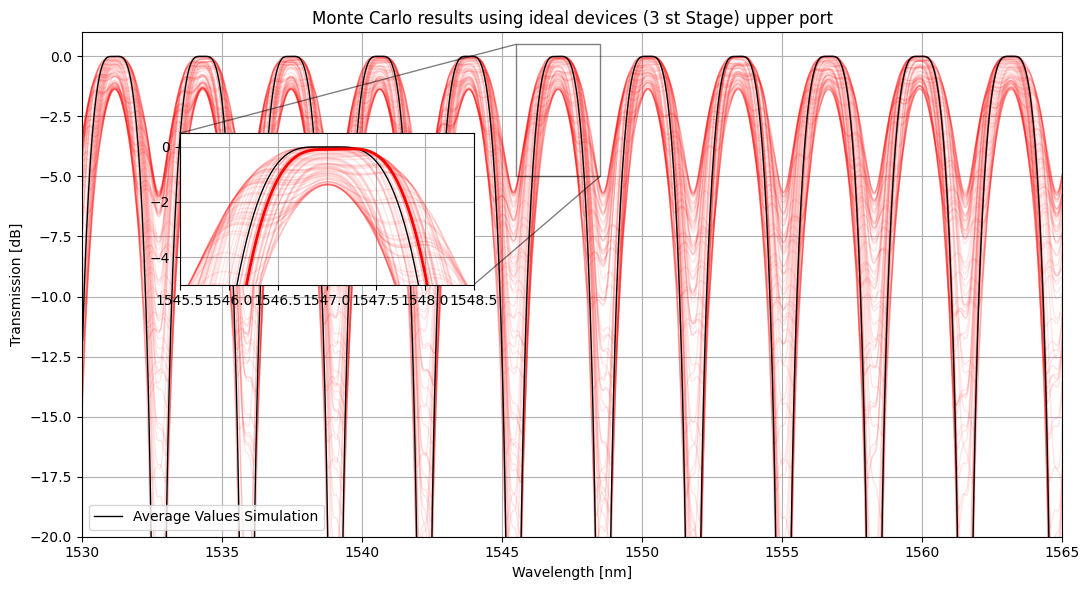

In [525]:
alfa = 0.1
plt.figure(figsize=(11, 6))
ax = plt.subplot(111)

ax.plot(wl / nm, res["TE gain (dB)"], linewidth=1, color='red', alpha=alfa)
data2 = icApi.getresult('ona1', 'input 9/mode 1/gain')
ax.plot(data2['wavelength']/nm, data2["TE gain (dB)"], color='black', linewidth=1, label='Average Values Simulation')

zoom = ax.inset_axes([0.1, 0.5, 0.3, 0.3])
zoom.plot(wl / nm, res["TE gain (dB)"], linewidth=1, color='red', alpha=alfa)
zoom.plot(data2['wavelength']/nm, data2["TE gain (dB)"], color='black', linewidth=1, label='Average Values Simulation')
zoom.plot(wl / nm, res["TE gain (dB)"][:,len(res)], linewidth=2, color='red', label='Monte Carlo simulation')
zoom.grid()
x1, x2, y1, y2 = 1545.5, 1548.5, -5, 0.5
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start / nm, wavelength_stop / nm)
plt.ylim(-20, 1)

plt.grid(True)
plt.title('Monte Carlo results using ideal devices (3 st Stage) upper port')
plt.legend()
plt.tight_layout()
plt.savefig('Monte Carlo results ideal.png', dpi=300)

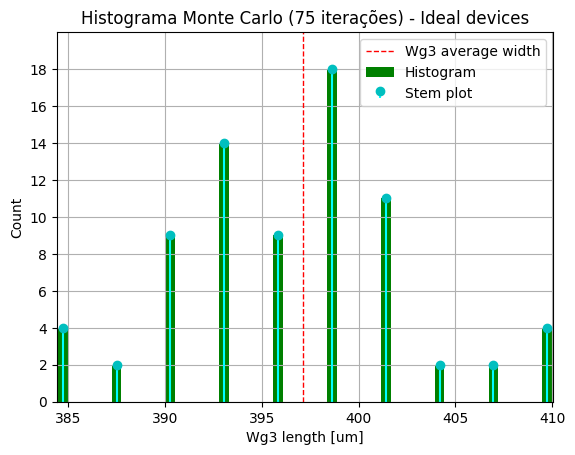

In [526]:
hist = icApi.getsweepresult(scriptName, 'analysis/parameters/histogram/wg3_length')
#hist
plt.bar(hist['wg3_length'].flatten()/um, hist['count'], label='Histogram', color='green', width=0.5)
plt.stem(hist['wg3_length'].flatten()/um, hist['count'], label='Stem plot', linefmt='cyan', markerfmt='co', basefmt=' ')
plt.xlim(hist['wg3_length'][0][0][0]/um-0.3, hist['wg3_length'][-1][-1][-1]/um +0.3)
plt.ylim(0, 20)
plt.yticks(np.arange(0, 20, 2))
plt.grid()
plt.vlines(397.138,0,20, color='red', linewidth=1, linestyles='--', label='Wg3 average width')
plt.xlabel('Wg3 length [um]')
plt.ylabel('Count')
plt.legend()
plt.title(f'Histograma Monte Carlo ({trials} iterações) - Ideal devices')
plt.savefig('histograma wg1length.png')

## Saída do estágio intermediário

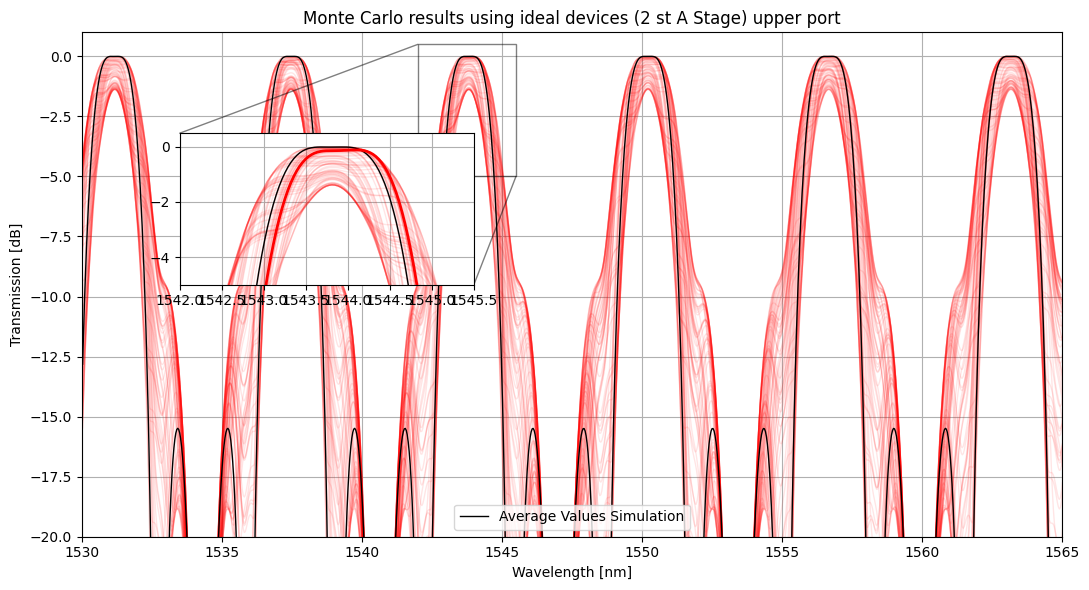

In [527]:
alfa = 0.1
plt.figure(figsize=(11, 6))
ax = plt.subplot(111)

ax.plot(wl / nm, res2["TE gain (dB)"], linewidth=1, color='red', alpha=alfa)
data2 = icApi.getresult('ona1', 'input 11/mode 1/gain')
ax.plot(data2['wavelength']/nm, data2["TE gain (dB)"], color='black', linewidth=1, label='Average Values Simulation')

zoom = ax.inset_axes([0.1, 0.5, 0.3, 0.3])
zoom.plot(wl / nm, res2["TE gain (dB)"], linewidth=1, color='red', alpha=alfa)
zoom.plot(data2['wavelength']/nm, data2["TE gain (dB)"], color='black', linewidth=1, label='Average Values Simulation')
zoom.plot(wl / nm, res2["TE gain (dB)"][:,len(res2)], linewidth=2, color='red', label='Monte Carlo simulation')
zoom.grid()
x1, x2, y1, y2 = 1542, 1545.5, -5, 0.5
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start / nm, wavelength_stop / nm)
plt.ylim(-20, 1)

plt.grid(True)
plt.title('Monte Carlo results using ideal devices (2 st A Stage) upper port')
plt.legend()
plt.tight_layout()
plt.savefig('Monte Carlo results ideal 2 st A upper.png', dpi=300)

## Saída final

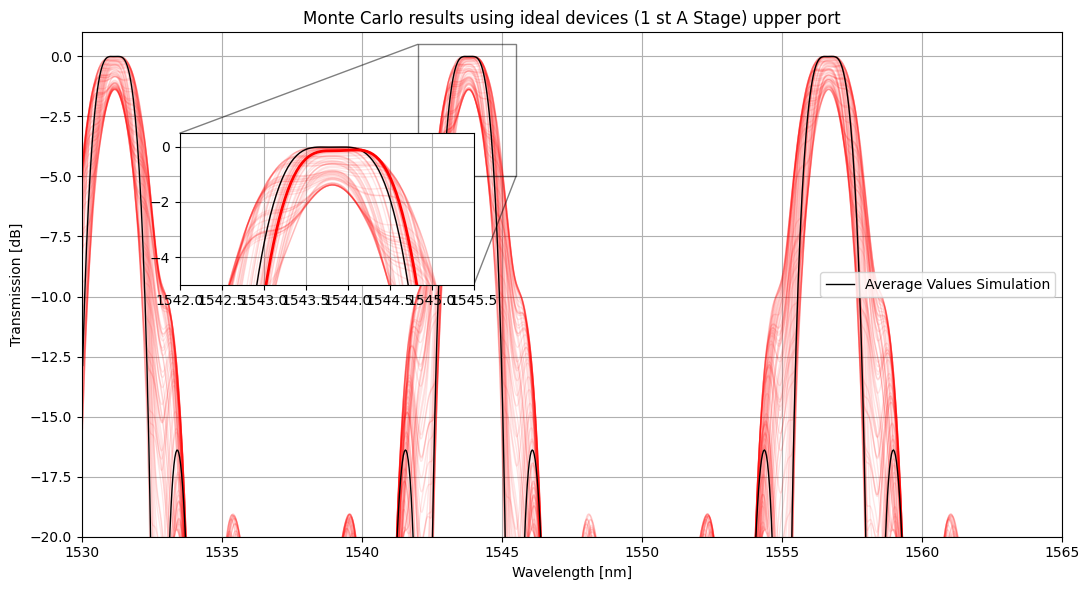

In [528]:
alfa = 0.1
plt.figure(figsize=(11, 6))
ax = plt.subplot(111)

ax.plot(wl / nm, res3["TE gain (dB)"], linewidth=1, color='red', alpha=alfa)
data3 = icApi.getresult('ona1', 'input 1/mode 1/gain')
ax.plot(data3['wavelength']/nm, data3["TE gain (dB)"], color='black', linewidth=1, label='Average Values Simulation')

zoom = ax.inset_axes([0.1, 0.5, 0.3, 0.3])
zoom.plot(wl / nm, res3["TE gain (dB)"], linewidth=1, color='red', alpha=alfa)
zoom.plot(data3['wavelength']/nm, data3["TE gain (dB)"], color='black', linewidth=1, label='Average Values Simulation')
zoom.plot(wl / nm, res3["TE gain (dB)"][:,len(res3)], linewidth=2, color='red', label='Monte Carlo simulation')
zoom.grid()
x1, x2, y1, y2 = 1542, 1545.5, -5, 0.5
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start / nm, wavelength_stop / nm)
plt.ylim(-20, 1)

plt.grid(True)
plt.title('Monte Carlo results using ideal devices (1 st A Stage) upper port')
plt.legend()
plt.tight_layout()
plt.savefig('Monte Carlo results ideal 1 st A upper.png', dpi=300)

## Todas as saídas do estágio final

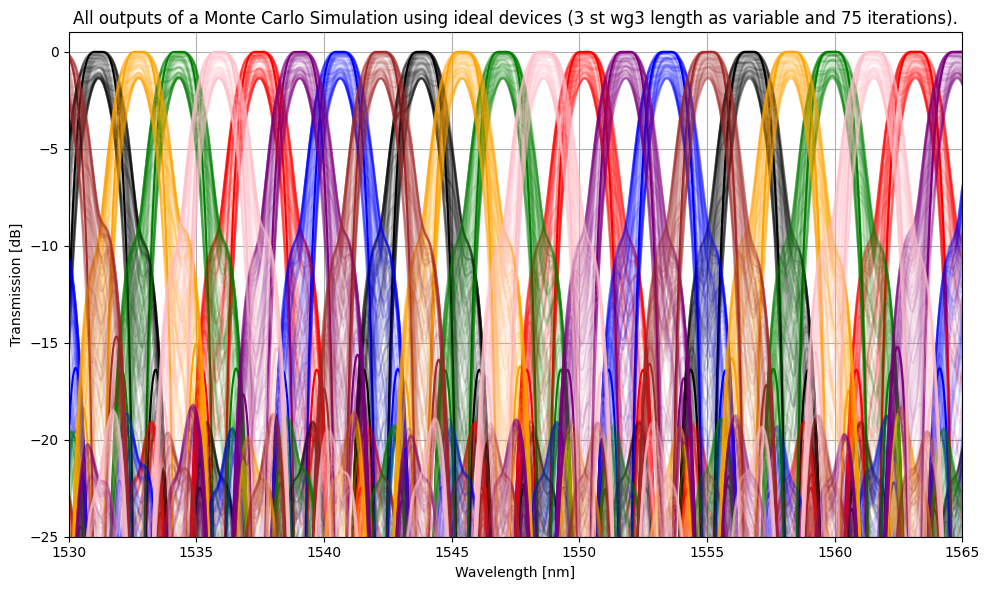

In [529]:
outputsOna = [
    'input 1/mode 1/gain',
    'input 2/mode 1/gain',
    'input 3/mode 1/gain',
    'input 4/mode 1/gain',
    'input 5/mode 1/gain',
    'input 6/mode 1/gain',
    'input 7/mode 1/gain',
    'input 8/mode 1/gain'
]
outputsOna2 = [
    'input 9/mode 1/gain',
    'input 10/mode 1/gain',
    'input 11/mode 1/gain',
    'input 11/mode 1/gain',
    'input 12/mode 1/gain',
    'input 13/mode 1/gain',
    'input 14/mode 1/gain'
    
]

transmissions = [
    'Transmission',
    'Transmission1',
    'Transmission2',
    'Transmission3',
    'Transmission4',
    'Transmission5',
    'Transmission6',
    'Transmission7',
    
]

colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
labels = [rf'$\lambda${i+1}' for i in range(8)]


plt.figure(figsize=(10,6))
ax = plt.subplot(111)
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    ax.plot(data['wavelength']/nm, data["TE gain (dB)"], color=colors[i])
    
for i, path in enumerate(outputsOna):
    dataSweep = icApi.getsweepresult(scriptName, transmissions[i])
    ax.plot(dataSweep['wavelength']/nm, dataSweep["TE gain (dB)"], color=colors[i], alpha=0.1)

'''zoom = ax.inset_axes([0.1,0.5,0.3,0.3])
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    zoom.plot(data['wavelength']/nm, data["TE gain (dB)"], color=colors[i])
zoom.grid()
x1, x2, y1, y2 = 1546, 1548, -2, 0.1
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)'''
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start/nm, wavelength_stop/nm)
plt.ylim(-25, 1)

plt.grid(True)
plt.title('All outputs of a Monte Carlo Simulation using ideal devices (3 st wg3 length as variable and 75 iterations).')
plt.tight_layout()
plt.savefig('TransmissionIdeal200GHz_MC.png', dpi=300)

## PDK devices

In [530]:
importlib.reload(tools)
icApi.switchtolayout()
icApi.deleteall()
tools.placeOna(icApi,'ona1',1000,-200,14,1000,c/wavelength_start, c/wavelength_stop)
for i in range(7):
    tools.MZILatticefilter(icApi,neff,ng,L,delayLengths_values[i],k,LC2nd,filenames, names[i], 3,2)

In [531]:
icApi.refresh()
position()
connect()

'wg3_length'

In [532]:
## Extra ona connections for each stage
## first stage
icApi.connect('ona1','input 9','3 st', 'port 3')
icApi.connect('ona1','input 10','3 st', 'port 4')
## second stage upper
icApi.connect('ona1','input 11','2 st A', 'port 3')
icApi.connect('ona1','input 12','2 st A', 'port 4')
##seconde stage lower
icApi.connect('ona1','input 13','2 st B', 'port 3')
icApi.connect('ona1','input 14','2 st B', 'port 4')

1.0

In [533]:
icApi.save('MonteCarlo_200GHz_circuit_PDK')
icApi.run()

## Monte Carlo

In [534]:
scriptName = 'Monte Carlo analysis'
icApi.deletesweep(scriptName)
icApi.addsweep(2)

'::Monte Carlo analysis'

In [535]:
trials = 75
scriptName = 'Monte Carlo analysis'
icApi.setsweep('Monte Carlo analysis','name', scriptName)
icApi.setsweep('Monte Carlo analysis', 'name', scriptName)
icApi.setsweep(scriptName, 'number of trials', trials)
icApi.setsweep(scriptName, 'batch size', trials)
icApi.setsweep(scriptName, 'enable seed', 1)
icApi.setsweep(scriptName, 'seed', 1)
icApi.setsweep(scriptName, 'Variation', 'Both')

1.0

## Comprimento do guia de onda Wg3

In [536]:
icApi.switchtolayout()
icApi.refresh()
icApi.groupscope('3 st')
param = icApi.struct()
param['Name'] = f'wg3_length'
param['Parameter'] = f'::Root Element::3 st::wg3::wg_length'
param['Value'] = icApi.getnamed(f'wg3', 'wg_length')
dis = icApi.struct()
dis['type'] = 'gaussian'
dis['variation'] = icApi.getnamed('wg3', 'wg_length')*(1.5/100)
param['Distribution'] = dis
icApi.addsweepparameter(scriptName, param)

'wg3_length'

In [537]:
Tr = icApi.struct()
Tr['Name'] = 'Transmission 3 st A upper port'
Tr['Result'] = f'::Root Element::ona1::input 9/mode 1/gain'
Tr['Estimation'] = False
icApi.addsweepresult(scriptName, Tr)

Tr2 = icApi.struct()
Tr2['Name'] = 'Transmission 3 st A lower port'
Tr2['Result'] = f'::Root Element::ona1::input 10/mode 1/gain'
Tr2['Estimation'] = False
icApi.addsweepresult(scriptName, Tr2)
##

Tr3 = icApi.struct()
Tr3['Name'] = 'Transmission 2 st A upper port'
Tr3['Result'] = f'::Root Element::ona1::input 11/mode 1/gain'
Tr3['Estimation'] = False
icApi.addsweepresult(scriptName, Tr3)

Tr4 = icApi.struct()
Tr4['Name'] = 'Transmission 2 st A lower port'
Tr4['Result'] = f'::Root Element::ona1::input 12/mode 1/gain'
Tr4['Estimation'] = False
icApi.addsweepresult(scriptName, Tr4)

##

Tr5 = icApi.struct()
Tr5['Name'] = 'Transmission 2 st B upper port'
Tr5['Result'] = f'::Root Element::ona1::input 13/mode 1/gain'
Tr5['Estimation'] = False
icApi.addsweepresult(scriptName, Tr5)

Tr6 = icApi.struct()
Tr6['Name'] = 'Transmission 2 st B lower port'
Tr6['Result'] = f'::Root Element::ona1::input 14/mode 1/gain'
Tr6['Estimation'] = False
icApi.addsweepresult(scriptName, Tr6)

##
for i in range(len(outputsOna)):
        Tr = icApi.struct()
        Tr['Name'] = "Transmission"
        Tr['Result'] = f"::Root Element::ona1::input {i + 1}/mode 1/gain"
        Tr['Estimation'] = True
        icApi.addsweepresult(scriptName, Tr)

In [538]:
icApi.save('mc_sweep')
icApi.runsweep(scriptName)

In [539]:
res = icApi.getsweepresult(scriptName, 'Transmission 3 st A upper port')
res2 = icApi.getsweepresult(scriptName, 'Transmission 2 st A upper port')
res3 = icApi.getsweepresult(scriptName, 'Transmission')
wl = res['wavelength'].flatten()

## Saída estagio de entrada

In [540]:
icApi.run()

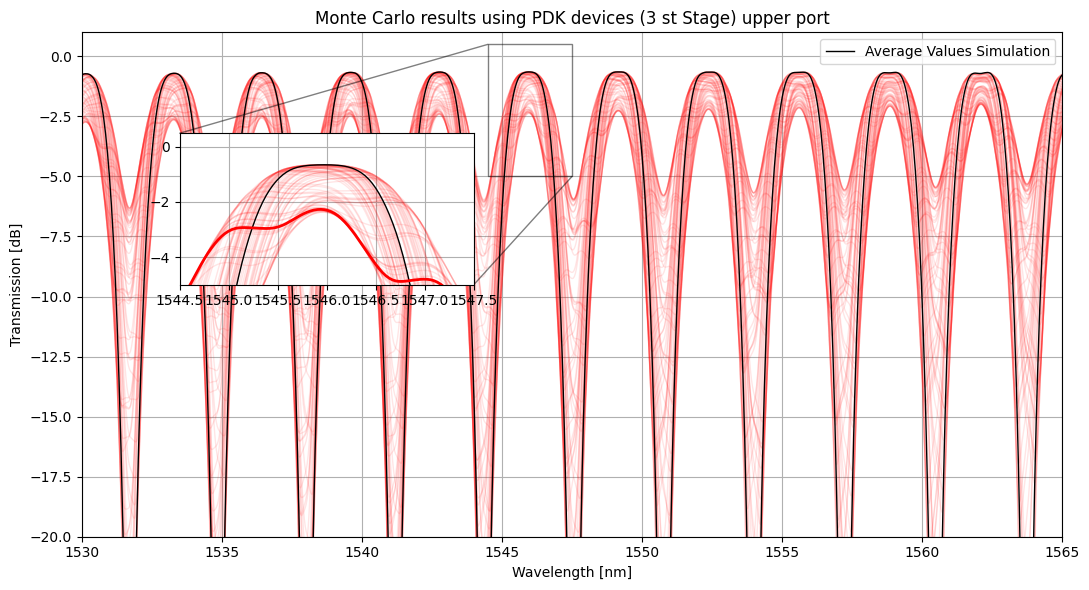

In [541]:
alfa = 0.1
plt.figure(figsize=(11, 6))
ax = plt.subplot(111)

ax.plot(wl / nm, res["'TE' gain (dB)"], linewidth=1, color='red', alpha=alfa)
data2 = icApi.getresult('ona1', 'input 9/mode 1/gain')
ax.plot(data2['wavelength']/nm, data2["'TE' gain (dB)"], color='black', linewidth=1, label='Average Values Simulation')

zoom = ax.inset_axes([0.1, 0.5, 0.3, 0.3])
zoom.plot(wl / nm, res["'TE' gain (dB)"], linewidth=1, color='red', alpha=alfa)
zoom.plot(data2['wavelength']/nm, data2["'TE' gain (dB)"], color='black', linewidth=1, label='Average Values Simulation')
zoom.plot(wl / nm, res["'TE' gain (dB)"][:,50], linewidth=2, color='red', label='Monte Carlo simulation')
zoom.grid()
x1, x2, y1, y2 = 1544.5, 1547.5, -5, 0.5
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start / nm, wavelength_stop / nm)
plt.ylim(-20, 1)

plt.grid(True)
plt.title('Monte Carlo results using PDK devices (3 st Stage) upper port')
plt.legend()
plt.tight_layout()
plt.savefig('Monte Carlo results ideal PDK.png', dpi=300)

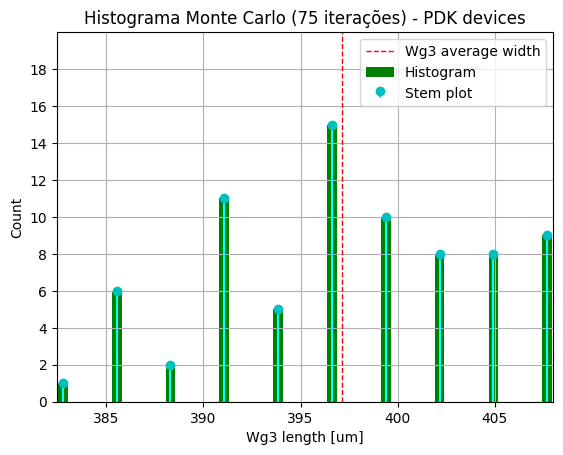

In [542]:
hist = icApi.getsweepresult(scriptName, 'analysis/parameters/histogram/wg3_length')
#hist
plt.bar(hist['wg3_length'].flatten()/um, hist['count'], label='Histogram', color='green', width=0.5)
plt.stem(hist['wg3_length'].flatten()/um, hist['count'], label='Stem plot', linefmt='cyan', markerfmt='co', basefmt=' ')
plt.xlim(hist['wg3_length'][0][0][0]/um-0.3, hist['wg3_length'][-1][-1][-1]/um +0.3)
plt.ylim(0, 20)
plt.yticks(np.arange(0, 20, 2))
plt.grid()
plt.vlines(397.138,0,20, color='red', linewidth=1, linestyles='--', label='Wg3 average width')
plt.xlabel('Wg3 length [um]')
plt.ylabel('Count')
plt.legend()
plt.title(f'Histograma Monte Carlo ({trials} iterações) - PDK devices')
plt.savefig('histograma wg1length PDK.png')

## Saída do estágio intermediário

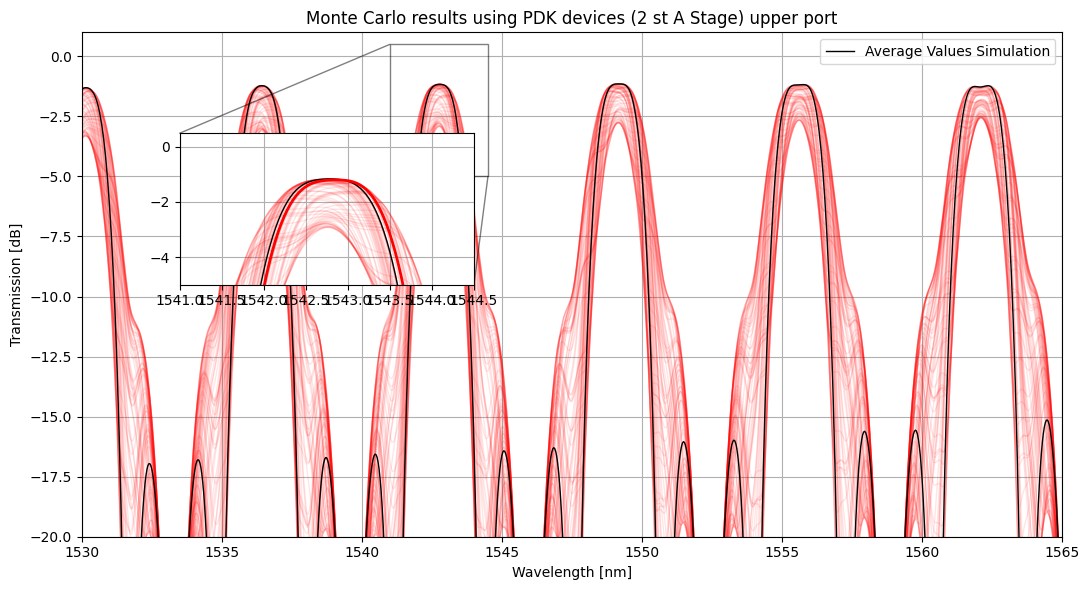

In [543]:
alfa = 0.1
plt.figure(figsize=(11, 6))
ax = plt.subplot(111)

ax.plot(wl / nm, res2["'TE' gain (dB)"], linewidth=1, color='red', alpha=alfa)
data2 = icApi.getresult('ona1', 'input 11/mode 1/gain')
ax.plot(data2['wavelength']/nm, data2["'TE' gain (dB)"], color='black', linewidth=1, label='Average Values Simulation')

zoom = ax.inset_axes([0.1, 0.5, 0.3, 0.3])
zoom.plot(wl / nm, res2["'TE' gain (dB)"], linewidth=1, color='red', alpha=alfa)
zoom.plot(data2['wavelength']/nm, data2["'TE' gain (dB)"], color='black', linewidth=1, label='Average Values Simulation')
zoom.plot(wl / nm, res2["'TE' gain (dB)"][:,0], linewidth=2, color='red', label='Monte Carlo simulation')
zoom.grid()
x1, x2, y1, y2 = 1541, 1544.5, -5, 0.5
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start / nm, wavelength_stop / nm)
plt.ylim(-20, 1)

plt.grid(True)
plt.title('Monte Carlo results using PDK devices (2 st A Stage) upper port')
plt.legend()
plt.tight_layout()
plt.savefig('Monte Carlo results 2 st A upper PDK.png', dpi=300)

## Saída final

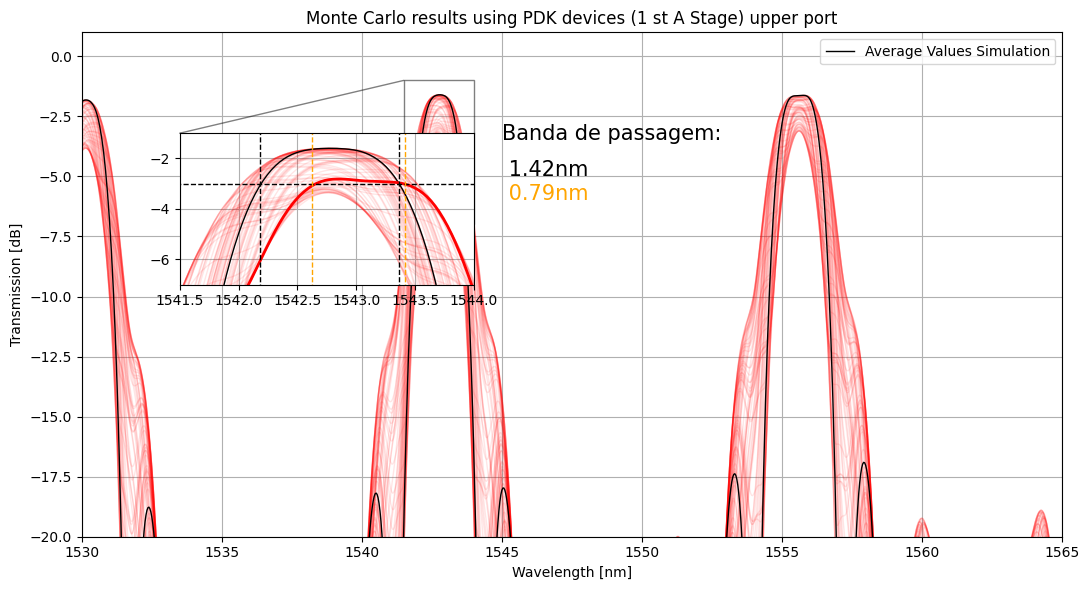

In [544]:
alfa = 0.1
plt.figure(figsize=(11, 6))
ax = plt.subplot(111)

ax.plot(wl / nm, res3["'TE' gain (dB)"], linewidth=1, color='red', alpha=alfa)
data3 = icApi.getresult('ona1', 'input 1/mode 1/gain')
ax.plot(data3['wavelength']/nm, data3["'TE' gain (dB)"], color='black', linewidth=1, label='Average Values Simulation')

zoom = ax.inset_axes([0.1, 0.5, 0.3, 0.3])
zoom.plot(wl / nm, res3["'TE' gain (dB)"], linewidth=1, color='red', alpha=alfa)
zoom.plot(data3['wavelength']/nm, data3["'TE' gain (dB)"], color='black', linewidth=1, label='Average Values Simulation')
zoom.plot(wl / nm, res3["'TE' gain (dB)"][:,22], linewidth=2, color='red', label='Monte Carlo simulation')
zoom.hlines(-3, wavelength_start/nm, wavelength_stop/nm, color='black', linewidth=1, linestyles='--', label='-3 dB')
zoom.vlines(1542.18, -20, 1, color='black', linewidth=1, linestyles='--')
zoom.vlines(1543.36, -20, 1, color='black', linewidth=1, linestyles='--')
zoom.vlines(1542.62, -20, 1, color='orange', linewidth=1, linestyles='--')
zoom.vlines(1543.41, -20, 1, color='orange', linewidth=1, linestyles='--')
zoom.grid()
x1, x2, y1, y2 = 1541.5, 1544, -7, -1
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start / nm, wavelength_stop / nm)
plt.ylim(-20, 1)
plt.text(1545, -3.5, 'Banda de passagem:', color='black', fontsize=15)
plt.text(1545, -5, ' 1.42nm', color='black', fontsize=15)
plt.text(1545, -6, ' 0.79nm', color='orange', fontsize=15)
plt.grid(True)
plt.title('Monte Carlo results using PDK devices (1 st A Stage) upper port')
plt.legend()
plt.tight_layout()
plt.savefig('Monte Carlo results 1 st A upper PDK.png', dpi=300)

## Todas as saídas do estágio final

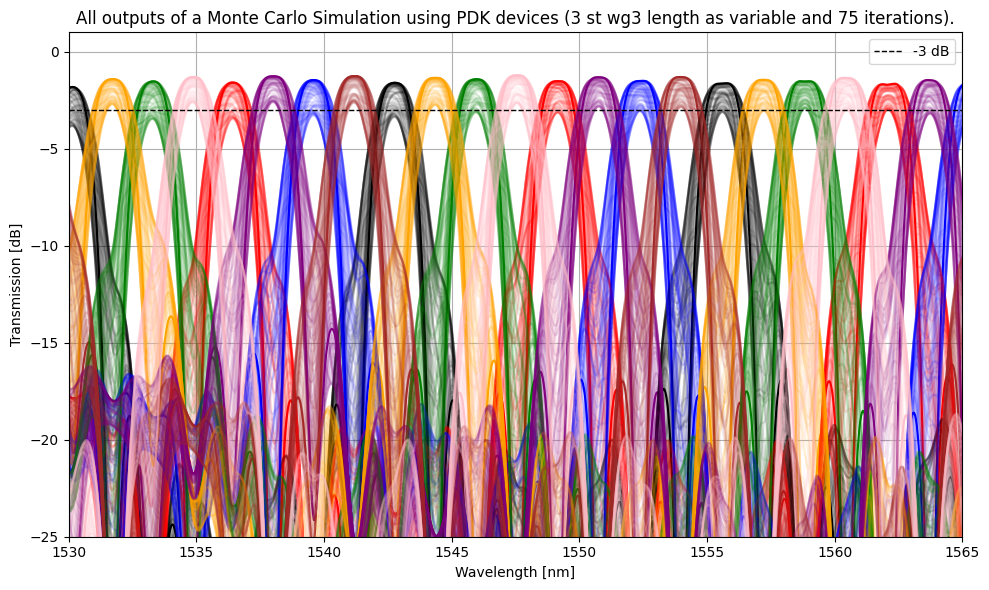

In [545]:
outputsOna = [
    'input 1/mode 1/gain',
    'input 2/mode 1/gain',
    'input 3/mode 1/gain',
    'input 4/mode 1/gain',
    'input 5/mode 1/gain',
    'input 6/mode 1/gain',
    'input 7/mode 1/gain',
    'input 8/mode 1/gain'
]
outputsOna2 = [
    'input 9/mode 1/gain',
    'input 10/mode 1/gain',
    'input 11/mode 1/gain',
    'input 11/mode 1/gain',
    'input 12/mode 1/gain',
    'input 13/mode 1/gain',
    'input 14/mode 1/gain'
    
]

transmissions = [
    'Transmission',
    'Transmission1',
    'Transmission2',
    'Transmission3',
    'Transmission4',
    'Transmission5',
    'Transmission6',
    'Transmission7',
    
]

colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
labels = [rf'$\lambda${i+1}' for i in range(8)]


plt.figure(figsize=(10,6))
ax = plt.subplot(111)
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    ax.plot(data['wavelength']/nm, data["'TE' gain (dB)"], color=colors[i])
    
for i, path in enumerate(outputsOna):
    dataSweep = icApi.getsweepresult(scriptName, transmissions[i])
    ax.plot(dataSweep['wavelength']/nm, dataSweep["'TE' gain (dB)"], color=colors[i], alpha=0.1)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start/nm, wavelength_stop/nm)
plt.ylim(-25, 1)
plt.hlines(-3, wavelength_start/nm, wavelength_stop/nm, color='black', linewidth=1, linestyles='--', label='-3 dB')
plt.grid(True)
plt.title(f'All outputs of a Monte Carlo Simulation using PDK devices (3 st wg3 length as variable and {trials} iterations).')
plt.legend()
plt.tight_layout()
plt.savefig('TransmissionIdeal200GHz_MC PDK.png', dpi=300)

## Quantos acima de -3dB?

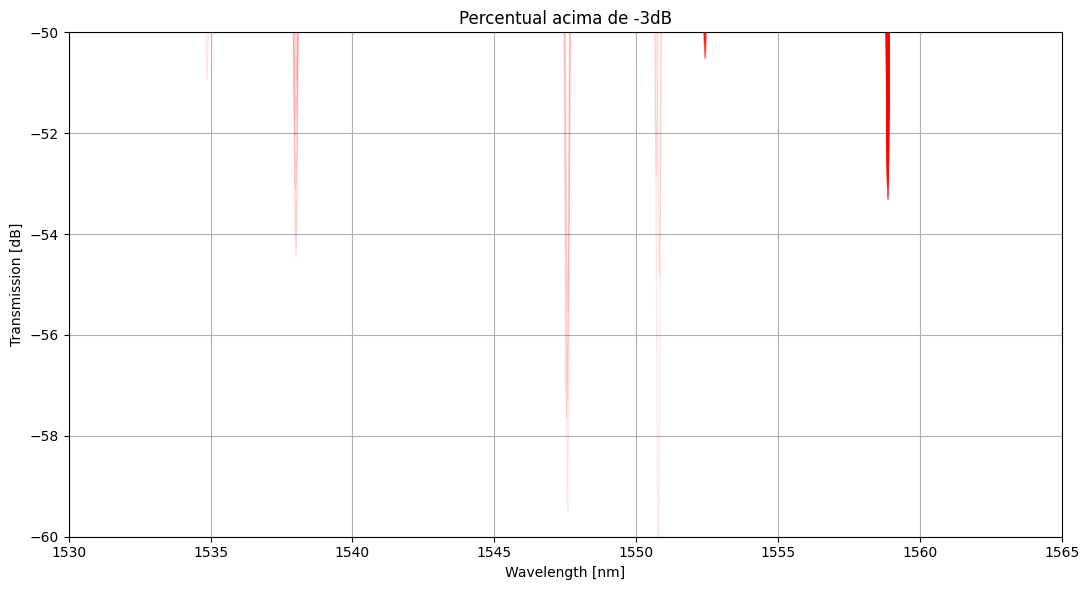

In [546]:
alfa = 0.1
plt.figure(figsize=(11, 6))
ax = plt.subplot(111)

ax.plot(wl / nm, res3["'TE' gain (dB)"], linewidth=1, color='red', alpha=alfa)
plt.hlines(-3, wavelength_start/nm, wavelength_stop/nm, color='black', linewidth=1, linestyles='--', label='-3 dB')

plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start / nm, wavelength_stop / nm)
plt.ylim(-60, -50)
plt.grid(True)
plt.title('Percentual acima de -3dB')
plt.tight_layout()

In [550]:
limite = -3
picos = np.max(res3["'TE' gain (dB)"], axis=0)
acima = np.sum(picos > limite)
print(f'Sinais acima de -3dB: {acima/len(picos)*100}%')

Sinais acima de -3dB: 92.0%
